<div class="alert alert-block alert-dark">

## <center> Group Project - ABCDEATS Customer Segmentation </center> <br>
#  <center> <b> Preprocessing </center> <br>
## <center> Master Data Science and Advanced Analytics <center>
## <center> Fall Semester 2024-2025 <center>
<br>
<center> Group 36: <center> <br>
<center>Eduardo Mendes, 20240850  <br><center>
<center>Joana Esteves, 20240746 <br><center>
<center>João Afonso Freire, 20240528 <br><center>
<center>Tomás Figueiredo, 20240941  <br><center>

<div>

**Description of contents:**
- Perfom preprocessing steps: correct data types; remove duplicates; input missing values, correct incongruencies; handle outliers and scale numeric data.
- Feature engineering: create new features that are more appropriate for segmentation and in order to enhance available information.
- After obtaining the final dataset, indentify redundancies and analyze which features may be more valuable to use for segmentation or as profiling variables.


**Table of Contents:**

- [1. Imports](#imports)

    - [1.1. Import the needed Libraries](#importlibraries)

    - [1.2. Import Dataset](#importdataset)

- [2. Preprocessing](#preprocessing)

    - [2.1 Correcting Data Types](#correctdatatype)

    - [2.2 Removing Duplicates](#removedup)

    - [2.3 Set index](#setindex)

    - [2.4 Missing Values](#missingvalues)

    - [2.5 Strange values](#strangevalues)

    - [2.6. Feature Engineering](#featureeng)

    - [2.7. Visualizations](#visualizations)

    - [2.8. Outliers](#outliers)

    - [2.9. Scaling](#scaling)

- [3. Analyze features](#features)

    - [3.1 Outliers for selected segmentations features](#outliersseg)

</a>





<a class="anchor" id="imports">

# **1. Imports**

</a>


<a class="anchor" id="importlibraries">

## 1.1. Import the needed Libraries

</a>
    


In [1]:
%pip install pyarrow

import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# Preprocessing
## Missing values
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
## Scaling
from sklearn.preprocessing import StandardScaler
## Outliers
from scipy.stats import zscore

# Warnings
import warnings

sns.set()


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Disable warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="importlibraries">

## 1.2. Import Dataset

</a>

In [3]:
df = pd.read_csv("DM2425_ABCDEats_DATASET.csv")

In [4]:
# Check first lines to see if it loaded correctly
df.head()

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23
0,1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,...,0,0,0,0,2,0,0,0,0,0
1,5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,...,0,0,0,0,0,0,0,0,0,0
2,f6d1b2ba63,4660,38.0,1,2,2,0.0,1,DISCOUNT,CASH,...,0,0,0,0,0,0,0,0,0,0
3,180c632ed8,4660,NaN,2,3,1,0.0,2,DELIVERY,DIGI,...,1,0,0,0,0,0,0,0,0,0
4,4eb37a6705,4660,20.0,2,5,0,0.0,2,-,DIGI,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Keep a copy of the original dataset (because we are applying some preprocessing)
df_original = df.copy()

<a class="anchor" id="preprocessing">

# **2. Preprocessing**

</a>

<a class="anchor" id="correctdatatype">

## **2.1 Correcting Data Types**

</a>

- customer_age, first_order and HR_0: These variables are discrete, as such the data type should be integer.

In [6]:
# Change the following variables from float to int
df['customer_age'] = df['customer_age'].astype("Int64")
df['first_order'] = df['first_order'].astype("Int64")
df['HR_0'] = df['HR_0'].astype("Int64")

# Check the changes
print(df.dtypes)

customer_id                  object
customer_region              object
customer_age                  Int64
vendor_count                  int64
product_count                 int64
is_chain                      int64
first_order                   Int64
last_order                    int64
last_promo                   object
payment_method               object
CUI_American                float64
CUI_Asian                   float64
CUI_Beverages               float64
CUI_Cafe                    float64
CUI_Chicken Dishes          float64
CUI_Chinese                 float64
CUI_Desserts                float64
CUI_Healthy                 float64
CUI_Indian                  float64
CUI_Italian                 float64
CUI_Japanese                float64
CUI_Noodle Dishes           float64
CUI_OTHER                   float64
CUI_Street Food / Snacks    float64
CUI_Thai                    float64
DOW_0                         int64
DOW_1                         int64
DOW_2                       

<a class="anchor" id="removedup">

## **2.2 Removing Duplicates**

</a>


In [7]:
# Remove duplicated instances
df = df.drop_duplicates()

<a class="anchor" id="setindex">

## **2.3 Set index**

</a>

In [8]:
# Set 'customer_id' as the index, since we don't have duplicates anymore
df.set_index('customer_id', inplace=True)

<a class="anchor" id="missingvalues">

## **2.4 Missing Values**

In [9]:
print(df.isna().sum()[df.isna().sum() > 0])

customer_age     727
first_order      106
HR_0            1164
dtype: int64


- customer_age: 2.28% of the entries are missing, since this is a low percentage it is not enough reason to remove this variable. As we want to retain as much information as possible for our analysis, we decided to imput the missing values using KNN with 5 neighbours, rather than removing the rows. We are aware this approach may introduce some bias into the clustering process, but we believe it is justified by the benefit of retaining additional information.

- first_order: Given our previous conclusion on the missing values for this variable, we will proced with inputing the value 0.

- HR_0: Since we don't have missing values for the number of orders in other hours (1-23), and the number of order by days of the week have no missing values either, we can calculate the true values to replace the missing values in this variable. If total orders by hours = total orders by day, we have:  orders at midnight = sum of orders for all days of the week - sum of orders for the other hours (1-23).

In [10]:
# Fill missing values in customer_age with knn imputer 
features_to_impute = ['customer_age']

imputer = KNNImputer(n_neighbors=5, weights="uniform")

df[features_to_impute] = imputer.fit_transform(df[features_to_impute])

# Round the imputed values
df[features_to_impute] = df[features_to_impute].round().astype(int)

In [11]:
# Impute missing values in 'first_order' by replacing NaNs with 0
df['first_order'] = df['first_order'].fillna(0)

In [12]:
# Calculate and impute missing values in 'HR_0'
# The value of 'HR_0' is determined by subtracting the sum of 'HR_1' to 'HR_23' from the total orders across all days
df['HR_0'] = df['HR_0'].fillna(df[['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6']].sum(axis=1) - df[[f'HR_{i}' for i in range(1, 24)]].sum(axis=1))

In [13]:
# Check if the sum of orders by day of the week and the sum of orders by hour it's the same in all rows after imputation
mismatch_rows = df[(df[['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6']].sum(axis=1))
                   != (df[['HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
                           'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
                           'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23']].sum(axis=1).astype(int))]
print(len(mismatch_rows))

0


In [14]:
# Check if there are no more missing values
print(df.isna().sum()[df.isna().sum() > 0])

Series([], dtype: int64)


<a class="anchor" id="strangevalues">

## **2.5 Strange values**

</a>


- customer_region: Given that we don't know the region of the customers that have the value "-" associated with this variable, we decided to replace this symbol with nan to input the values with Knn inputer. We decided on this approach for 3 reasons:
  - We believe it's more effective to impute the values for missing region in order to keep this instances information in other useful variables, over deleting the corresponding rows, as it retains more data for analysis.
  - The percentage of such instances is low, so the variable is still valuable and interpretable and should not be removed.
  - Since this is a categorical variable creating a label for these customers could group them as if they shared a common region, which is likely not the case.

- last_promo: As previously stated we belive the "-" represents costumers who did not use a promotion code, indicating a common trait among these customers. Since this is a categorical variable, it makes sense to create a category for those who did not use a promotion code. So, we decided to label this symbol as "No Promo Code."

- vendor_count and product_count: Given that the variables payment_method and last_order have no missing values we assume all customers have made at least one order. So a value of 0 for these variables seems to be an inconsistency and does not represent true values: 
  - There are 18 observations for region "4660" where vendor count is different from 0, and product count is 0, we decided to replace that zero by the vendor count value, because we consider that there was a mistake in that region (4660) and there needs to be at least one product ordered per vendor.
  - There are 138 observations where vendor and product count are both 0, this is not possible so we will remove this observations.


In [15]:
# Substitute the "-" values in last_promotion with a label indicating those customer did not use a promotion code
df['last_promo'] = df['last_promo'].replace('-', 'No Promo Code')

In [16]:
# Replace '-' with NaN
df['customer_region'] = df['customer_region'].replace('-', np.nan)

# Keep track of missing rows
missing_mask = df['customer_region'].isna()

# One-hot encode the categorical variable
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[['customer_region']])

# Apply KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputed_data = imputer.fit_transform(encoded_data)

# Convert back to categories
imputed_categories = encoder.inverse_transform(imputed_data)

# Only replace missing values
df.loc[missing_mask, 'customer_region'] = imputed_categories[missing_mask].flatten()

In [17]:
# Replace 0 in product_coun, where vendor_count is different from 0, with vendor_count value 
df.loc[(df['vendor_count'] != 0) & (df['product_count'] == 0), 'product_count'] = df['vendor_count']

In [18]:
# Drop rows where both 'vendor_count' and 'product_count' are equal to 0
df = df[~((df['vendor_count'] == 0) & (df['product_count'] == 0))]

<a class="anchor" id="featureeng">

## **2.6 Feature engineering**

**Metadata**
- **weekend_orders**: Captures the total orders placed from Monday to Friday.

- **weekdays_orders**: Captures the total orders placed on Saturday and Sunday.

- **proportion_weekdays, proportion_weekend**: The proportion of orders the client has made for each week time in the total of orders made.

- **breakfast, lunch, snack, dinner, late_night**: Result of grouping individual hour based orders into categories according to meal times: Breakfast, Lunch, Snach, Dinner and Late-night.

- **proportion_breakfast, proportion_lunch, proportion_snack, proportion_dinner, proportion_late_night**: The proportion of orders the client has made for each meal time in the total of orders made.

- **age_group**: Categorizes customer age into three groups: Young (0-24), Adult (25-59), and Senior (60+).

- **use_promo**: Indicates whether a ever customer has used a promotion code.

- **total_orders**: Represents the cumulative number of orders placed by each customer.

- **total_spent**: Indicates the total spending amount for each customer across all orders.

- **avg_spent_per_order**: Indicates the average value a costumer spends per order.

- **avg_products_per_order**: Indicates the average number of products bought per order.

- **avg_price_per_product**: Indicates on average how much the client spents per product. 

- **recency**: Indicates how recently the customer made their last order relative to the dataset's timeframe

- **active_period**: Indicates how much time the client was active for the 3 month period.

- **order_frequency**: Indicates the frequency of orders for the time between first and last order.

- **cusine_diversity**: Represents the number of different cuisines the customer has ordered from.

- **vendor_loyalty**: Measures customer loyalty to the vendors.

- **weekend_preference**: Indicates if the customers orders more on the weekends or on weekdays.

- **meal_time_preference**: Indicates the meal time where the customer has ordered the most.

- **cuisine_preference**: Indicates the cuisine type that the customer has ordered the most.


**Groupig orders by weekdays and weekends:**
- Reducing daily orders (seven columns) to just two columns simplifies the dataset, decreasing its dimensionality. Lower dimensions improve clustering performance and computational efficiency.
- By dividng orders between weekdays and weekends, it becomes easier to observe trends in customer behavior as the segmentation becomes more interpretable.

**Proportions of week time in total orders:**
- Allows to understand the customers preferences for certain week times: weekdays or weekends.

**Grouping Orders by Meal Times:**
- Reduces the number of columns (24 individual hours) to more manageable categories, which can be helpful to clustering by reducing noise and improving interpretability.
- Time-based grouping provides a clearer view of order patterns, which can be easily plotted and analyzed.

**Proportions of orderd by meal time in total orders:**
- Allows to understand the customers preferences for certain meal times.

**Grouping Age into Categories:**
- Simplifies age data, making it easier to identify trends and patterns in customer segments.
- Age groups help in comparing purchasing behaviors and preferences.

**Use of promotion code:**
- This variable helps analyze which segments are more likely to use promotion code.

**Total Orders:**
- This is feature is a good indicator of customer activity.
- Using this variable for clustering can help differenciate between more and less active costumers.

**Total Spent:**
- This feature makes it easier to identify customers expenditure.
- This feature allows easy segmentation of high spending customers vs. low spending.

**Average spent per order:**
- Allows us to differentiate between costumer that spent a lot because they make many orders or because they spent a lot because the few orders they made were expensive. As weel, as costumers who spent less because they made a low number of orders and those who made more orders but spent less on each. 

**Average number of products per order:**
- Allows us to differentiate between costumer that bought a high number of products because they make many orders or because in the few orders they made they ordered high quantities (on average). As weel, as costumers who have bough a smaller number of products because they made a low number of orders and those who made more orders but only bough a small number of products. 

**Average price per product:**
- Allows us to differenciate between customers with a high average price per product that tend to buy expensive items and customers with a low average price per product that tend to buy cheaper items.

**Recency:**
- Allows to differentiate between customers that were active recently and those that have not been active for some time.

**Active period:**
- This feature helps identify customers who that have a short recency versus those whose activity has a long recency.

**Order frequency:**
- Captures how often a customer places orders, considering the total number of orders relative to the time they’ve been active, differntiating between frequent buyers and non-frequent buyers. 

**Cusine Diversity:** 
- Reflects the variety of cuisines a customer orders from by counting the number of different cuisines they’ve tried. This feature helps distinguish customers with wider culinary tastes from those with narrow preferences.

**Weekend preference:**
- This variable can differentiate between costumers that have a preference for ordering during the weekends and those who order more during the weekdays.

**Meal time preference:**
- Indicates the prefered meal times of customers, allowing to understand which meal time they order the most.

**Cuisine preference:**
- Indicates the prefered cuisine type of customers, allowing to understand which cuisine type they order the most.


- **Weekend_orders** 

In [19]:
# Create a new column 'weekend_orders'
# The column states the number of orders the client did on the weekends
df['weekend_orders'] = df['DOW_0'] + df['DOW_6']

In [20]:
df = df.drop('DOW_0', axis=1)
df = df.drop('DOW_6', axis=1)

- **Weekdays_orders** 

In [21]:
# Create a new column 'weekdays_orders'
# The column states the number of orders the client did on weekdays
df['weekdays_orders'] = df['DOW_1'] + df['DOW_2'] + df['DOW_3'] + df['DOW_4'] + df['DOW_5']

In [22]:
# Drop all DOW columns
df = df.drop([f'DOW_{i}' for i in range(1, 6)], axis=1)

- **Total_orders** <br>

In [23]:
# Create 'total_orders' to sum all orders made during the week
df['total_orders'] = df[['weekdays_orders', 'weekend_orders']].sum(axis=1)

- **Proportion of weekend and weekdays orders in total_orders:**

In [24]:
# Calculate the proportion of orders
df['proportion_weekend'] = df['weekend_orders'] / df['total_orders']
df['proportion_weekdays'] = df['weekdays_orders'] / df['total_orders']

- **Variables with number of orders for each meal**

In [25]:
# Create variables with the number of orders for each meal time
# Each column states the number of orders the client did for each meal time

hour_columns = [f'HR_{i}' for i in range(24)]

df['breakfast'] = df[hour_columns[6:11]].sum(axis=1)
df['lunch'] = df[hour_columns[11:15]].sum(axis=1)
df['snack'] = df[hour_columns[15:18]].sum(axis=1)
df['dinner'] = df[hour_columns[18:22]].sum(axis=1)
df['late_night'] = df[hour_columns[22:] + hour_columns[:6]].sum(axis=1)


In [26]:
# Drop all HR columns
df = df.drop([f'HR_{i}' for i in range(24)], axis=1)

- **Proportion of meal time orders in total_orders**

In [27]:
# Calculate the proportions for each meal period
df['proportion_breakfast'] = df['breakfast'] / df['total_orders']
df['proportion_lunch'] = df['lunch'] / df['total_orders']
df['proportion_snack'] = df['snack'] / df['total_orders']
df['proportion_dinner'] = df['dinner'] / df['total_orders']
df['proportion_late_night'] = df['late_night'] / df['total_orders']

- **Age_group**

In [28]:
# Create 'age_group' to classify customers by age
# Assign 'young' if age < 25, 'adult' if 25 <= age < 60, 'senior' if age >= 60
df['age_group'] = pd.cut(df['customer_age'], bins=[0, 24, 59, 120], labels=['young', 'adult', 'senior'], right=False)

- **Use_promo**

In [29]:
# Create 'use_promo' as a binary column (1 if the customer used a promotion, 0 if they did not)
# Consider '-' in 'last_promo' as no promotion used
df['use_promo'] = (df['last_promo'] != 'No Promo Code').astype(bool)      

- **Average_spent_per_order** <br>

In [30]:
# Select all the columns that starts with "CUI_"
cui_columns = [col for col in df.columns if col.startswith('CUI_')]
# Calculate 'total_spent' by summing all the spent across all cuisine types
df['total_spent'] = df[cui_columns].sum(axis=1)

In [31]:
# Calculate average spent per order
df['avg_spent_per_order'] = df['total_spent'] / df['total_orders']

- **Average_products_per_order**

In [32]:
# Calculate average products per order
df['avg_products_per_order'] = df['product_count'] / df['total_orders']

- **Average_price_per_product**

In [33]:
# Calculate average price per product
df['avg_price_per_product'] = df['avg_spent_per_order'] / df['avg_products_per_order']

- **Recency**

In [34]:
# Calculate recency (assuming dataset includes a 3 month = 90 days period
df['recency'] = 90 - df['last_order']

- **Active_period**

In [35]:
# Calculate active period (time between first and last order) 
df['active_period'] = df['last_order'] - df['first_order'] + 1 

- **Order_frequency** 

In [36]:
# Calculate order frequency (total orders per active period)
df['order_frequency'] = df['total_orders'] / df['active_period']

- **Cuisine_diversity**

In [37]:
# Calculate cuisine diversity with the count of nonzero cuisine columns
cuisine_columns = [col for col in df.columns if col.startswith('CUI_')]
df['cuisine_diversity'] = df[cuisine_columns].gt(0).sum(axis=1)

- **Vendor_loyalty**

In [38]:
# Calculate vendor loyalty
df['vendor_loyalty'] = df['vendor_count'] / df['total_orders']

- **Weekend_preference**

In [39]:
# 1 if the customer orders more on the weekends
df['weekend_preference'] = (df['weekend_orders'] > df['weekdays_orders']).astype(bool)

- **Meal_time_preference**

In [40]:
meal_columns = ['breakfast', 'lunch', 'snack', 'dinner', 'late_night']
df['meal_time_preference'] = df[meal_columns].idxmax(axis=1)

- **Cuisine_preference**

In [41]:
cuisine_columns = [col for col in df.columns if col.startswith('CUI')]
df['cuisine_preference'] = df[cuisine_columns].idxmax(axis=1)

Check dataset after creating new features:

In [42]:
df.head(10)

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,avg_products_per_order,avg_price_per_product,recency,active_period,order_frequency,cuisine_diversity,vendor_loyalty,weekend_preference,meal_time_preference,cuisine_preference
customer_id,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,2360,18,2,5,1,0,1,DELIVERY,DIGI,0.00,...,2.500000,5.776000,89,2,1.0,1,1.0,True,dinner,CUI_Indian
5d272b9dcb,8670,17,2,2,2,0,1,DISCOUNT,DIGI,12.82,...,1.000000,9.605000,89,2,1.0,2,1.0,True,breakfast,CUI_American
f6d1b2ba63,4660,38,1,2,2,0,1,DISCOUNT,CASH,9.20,...,1.000000,4.600000,89,2,1.0,1,0.5,True,breakfast,CUI_American
180c632ed8,4660,28,2,3,1,0,2,DELIVERY,DIGI,0.00,...,1.500000,10.520000,88,3,0.666667,2,1.0,False,lunch,CUI_Indian
4eb37a6705,4660,20,2,5,0,0,2,No Promo Code,DIGI,14.57,...,2.500000,11.088000,88,3,0.666667,2,1.0,False,breakfast,CUI_Asian
6aef2b6726,8670,40,2,2,0,0,2,FREEBIE,DIGI,0.00,...,1.000000,12.460000,88,3,0.666667,1,1.0,False,late_night,CUI_Asian
8475ee66ef,2440,24,2,2,2,0,2,No Promo Code,CARD,5.88,...,1.000000,3.705000,88,3,0.666667,2,1.0,False,lunch,CUI_American
f2f53bcc67,8670,27,2,3,2,0,2,DISCOUNT,DIGI,11.71,...,1.500000,12.036667,88,3,0.666667,2,1.0,False,breakfast,CUI_Beverages
5b650c89cc,2360,20,3,4,2,0,3,DISCOUNT,DIGI,2.75,...,1.333333,3.610000,87,4,0.75,3,1.0,True,snack,CUI_OTHER


In [43]:
df.dtypes

customer_region               object
customer_age                   int64
vendor_count                   int64
product_count                  int64
is_chain                       int64
first_order                    Int64
last_order                     int64
last_promo                    object
payment_method                object
CUI_American                 float64
CUI_Asian                    float64
CUI_Beverages                float64
CUI_Cafe                     float64
CUI_Chicken Dishes           float64
CUI_Chinese                  float64
CUI_Desserts                 float64
CUI_Healthy                  float64
CUI_Indian                   float64
CUI_Italian                  float64
CUI_Japanese                 float64
CUI_Noodle Dishes            float64
CUI_OTHER                    float64
CUI_Street Food / Snacks     float64
CUI_Thai                     float64
weekend_orders                 int64
weekdays_orders                int64
total_orders                   int64
p

- The average values, order_frequency and vendor_loyalty will be retained as float to perserve variablity.

In [44]:
# Retrieve metric (numerical) features
metric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Retrieve non-metric features
non_metric_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Metric Features:", metric_features)
print("Non-Metric Features:", non_metric_features)

Metric Features: ['customer_age', 'vendor_count', 'product_count', 'is_chain', 'first_order', 'last_order', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'weekend_orders', 'weekdays_orders', 'total_orders', 'proportion_weekend', 'proportion_weekdays', 'breakfast', 'lunch', 'snack', 'dinner', 'late_night', 'proportion_breakfast', 'proportion_lunch', 'proportion_snack', 'proportion_dinner', 'proportion_late_night', 'total_spent', 'avg_spent_per_order', 'avg_products_per_order', 'avg_price_per_product', 'recency', 'active_period', 'order_frequency', 'cuisine_diversity', 'vendor_loyalty']
Non-Metric Features: ['customer_region', 'last_promo', 'payment_method', 'age_group', 'use_promo', 'weekend_preference', 'meal_time_preference', 'cuisine_preference']


In [45]:
# Save dataset with new features before any change to the observations values
df_original_values = df.copy()

<a class="anchor" id="visualizations">

## **2.7 Visualizations**

</a>

In [46]:
# Style and palette configuration
sns.set_theme(style="whitegrid")
palette = sns.color_palette("tab20", n_colors=24)

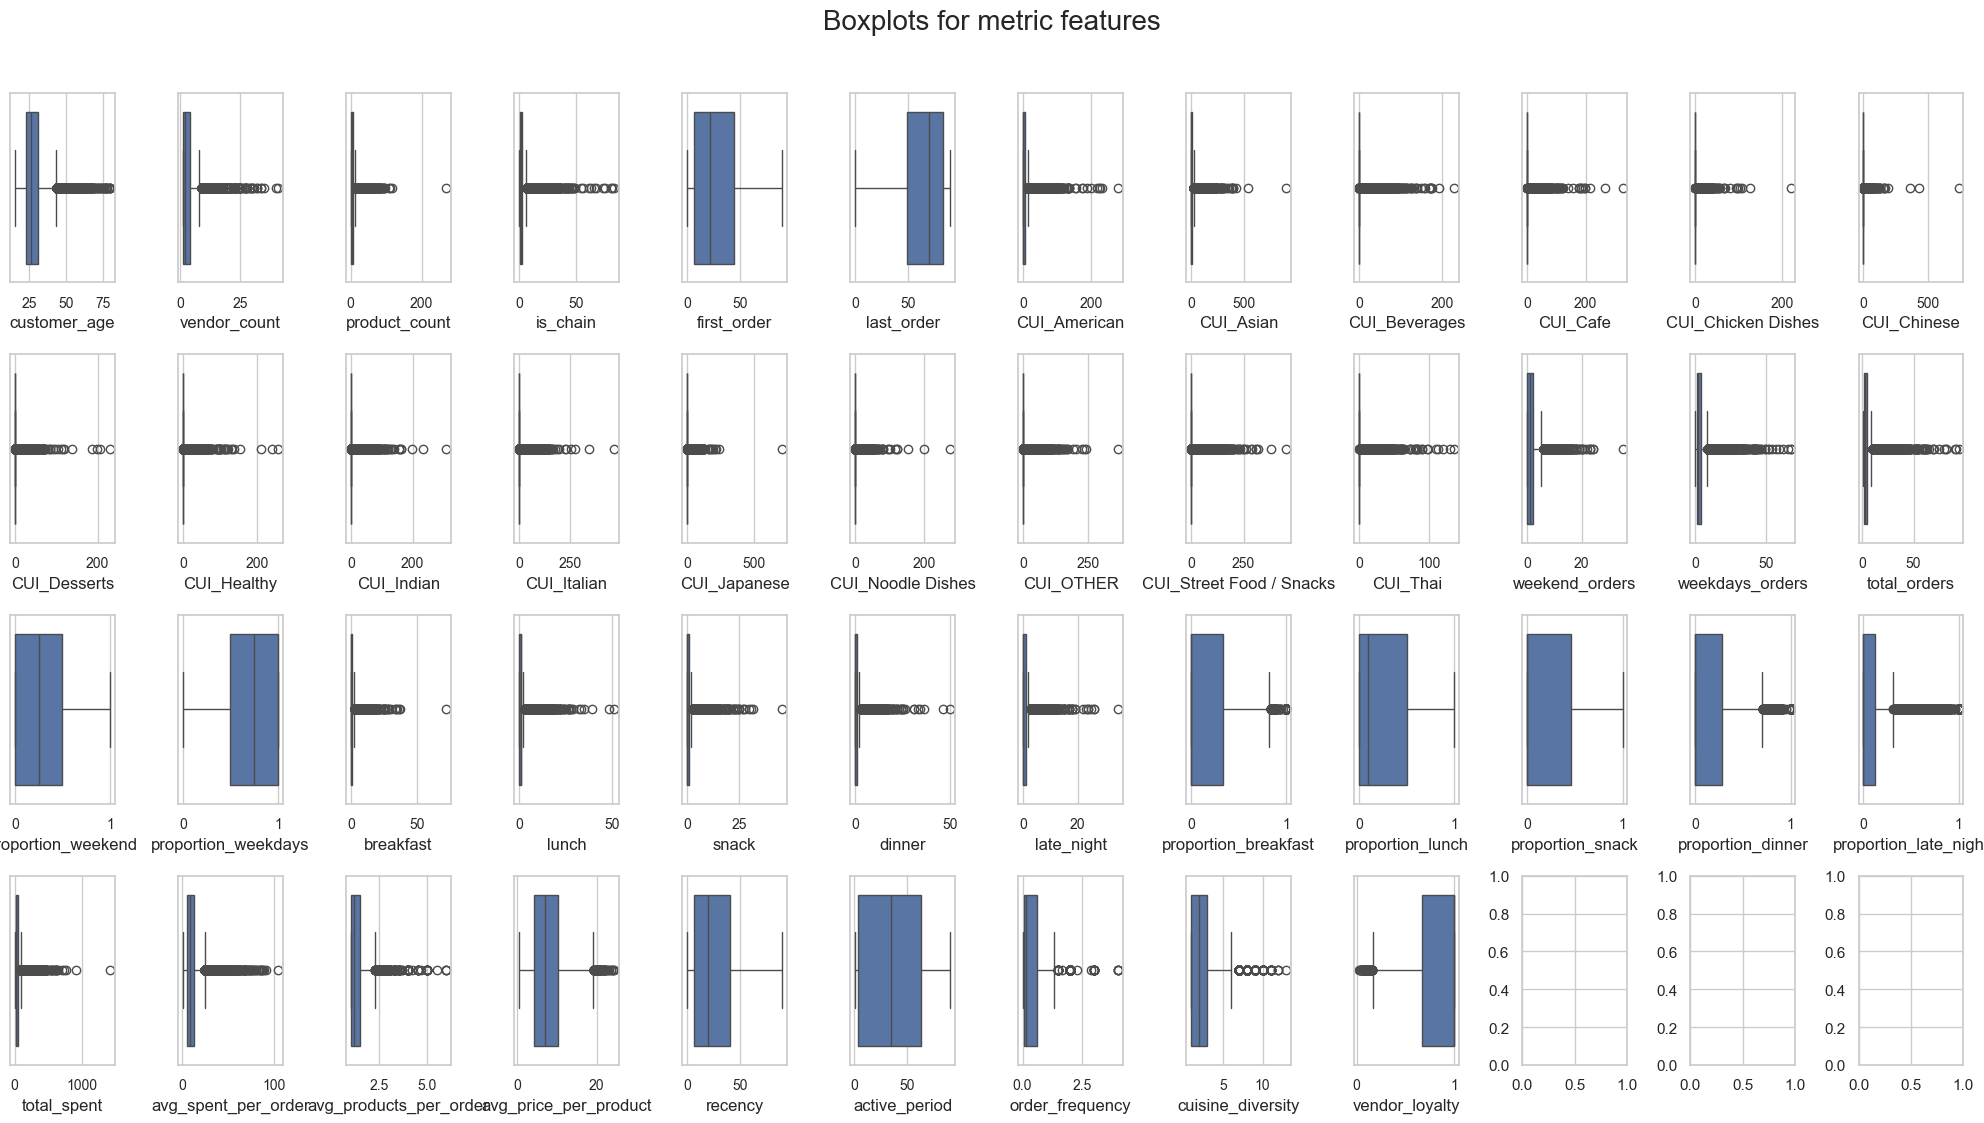

In [47]:
# Boxplots for metric features
sp_rows=4
sp_cols=ceil(len(metric_features) / sp_rows)

# Prepare figure and create individual axes
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 11), tight_layout=True)

# Plot data
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=10)  # Tick size

# Ttitle of the figure
plt.suptitle("Boxplots for metric features", fontsize=20, y=1.02)

# Show the plot
plt.show()

- We have several right skewed variables, in most cases due to the high number of zeros.
- Cuisine related variables are very sparse due to high number of zeros vs. high values.
- The majority of the features have outliers, which seems to represent true but very extreme cases.

<a class="anchor" id="outliers">

## **2.8 Outliers**

</a>

In [48]:
df_with_outliers = df.copy()

In [49]:
#Start by computing the interquartile range
q1 = df[metric_features].quantile(0.25)
q3 = df[metric_features].quantile(0.75)
iqr = q3 - q1

#Now we are going to compute the limits:
lower_lim = q1 - (1.5 * iqr)
upper_lim = q3 + (1.5 * iqr)

for feature in metric_features:
    print(f"{feature:<25}  Lower Limit: {lower_lim[feature]:>10}      Upper Limit: {upper_lim[feature]:>10}")

customer_age               Lower Limit:       11.0      Upper Limit:       43.0
vendor_count               Lower Limit:       -3.5      Upper Limit:        8.5
product_count              Lower Limit:       -5.5      Upper Limit:       14.5
is_chain                   Lower Limit:       -2.0      Upper Limit:        6.0
first_order                Lower Limit:      -48.5      Upper Limit:       99.5
last_order                 Lower Limit:       -2.0      Upper Limit:      134.0
CUI_American               Lower Limit:     -8.565      Upper Limit: 14.274999999999999
CUI_Asian                  Lower Limit:     -17.79      Upper Limit:      29.65
CUI_Beverages              Lower Limit:        0.0      Upper Limit:        0.0
CUI_Cafe                   Lower Limit:        0.0      Upper Limit:        0.0
CUI_Chicken Dishes         Lower Limit:        0.0      Upper Limit:        0.0
CUI_Chinese                Lower Limit:        0.0      Upper Limit:        0.0
CUI_Desserts               Lower

In [50]:
def identify_outliers(df, metric_features, lower_lim, upper_lim):
    outliers = {}
    obvious_outliers = []

    for metric in metric_features:
        if metric not in df.columns:
            continue
        
        if metric not in lower_lim or metric not in upper_lim:
            continue
        
        outliers[metric] = []
        llim = lower_lim[metric]
        ulim = upper_lim[metric]
        
        for i, value in enumerate(df[metric]):
            if pd.isna(value):
                continue
            
            if value < llim or value > ulim:
                outliers[metric].append(value)
        
        print(f"Total outliers in {metric}: {len(outliers[metric])}")

    # Check for observations that are outliers in all features (Obvious Outliers)
    for index, row in df.iterrows():
        is_global_outlier = True
        for metric in metric_features:
            if metric not in df.columns or metric not in lower_lim or metric not in upper_lim:
                is_global_outlier = False
                break
            
            value = row[metric]
            if pd.isna(value):
                is_global_outlier = False
                break
            
            llim = lower_lim[metric]
            ulim = upper_lim[metric]
            
            if llim <= value <= ulim:
                is_global_outlier = False
                break
        
        if is_global_outlier:
            obvious_outliers.append(index)
    print("-----------------------------")
    print(f"Total global outliers: {len(obvious_outliers)}")
    return outliers, obvious_outliers
    
    
outliers, obvious_outliers = identify_outliers(df, metric_features, lower_lim, upper_lim)


Total outliers in customer_age: 1078
Total outliers in vendor_count: 1523
Total outliers in product_count: 2370
Total outliers in is_chain: 3154
Total outliers in first_order: 0
Total outliers in last_order: 0
Total outliers in CUI_American: 3482
Total outliers in CUI_Asian: 3462
Total outliers in CUI_Beverages: 5431
Total outliers in CUI_Cafe: 1366
Total outliers in CUI_Chicken Dishes: 3248
Total outliers in CUI_Chinese: 3522
Total outliers in CUI_Desserts: 2016
Total outliers in CUI_Healthy: 2169
Total outliers in CUI_Indian: 3448
Total outliers in CUI_Italian: 6448
Total outliers in CUI_Japanese: 6300
Total outliers in CUI_Noodle Dishes: 2226
Total outliers in CUI_OTHER: 7041
Total outliers in CUI_Street Food / Snacks: 4244
Total outliers in CUI_Thai: 2378
Total outliers in weekend_orders: 958
Total outliers in weekdays_orders: 2095
Total outliers in total_orders: 3027
Total outliers in proportion_weekend: 0
Total outliers in proportion_weekdays: 0
Total outliers in breakfast: 2940


Filter to verify if an observation has every characteristic in the Interquartile Range or not:

In [51]:
filters_iqr = []                                            
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters_iqr.append(df[metric].between(llim, ulim, inclusive='neither'))

filters_iqr_all = pd.concat(filters_iqr, axis=1).all(axis=1)

In [52]:
# Count rows where no feature has outliers
count_true= len(df[filters_iqr_all])

# Count rows that have at least one feature with outliers
count_false = len(df[~filters_iqr_all])

print(f"True count: {count_true}")
print(f"False count: {count_false}")

True count: 0
False count: 31737


**Conclusions:**
- There is not a single observations with outliers for all features.
- There is not a single observation whith no outliers for all features.

**Univariate outliers:**

In [53]:
# IQR method

outlier_indices_iqr = set()

for feature in metric_features:

    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    outlier_indices_iqr.update(outliers) 

percentage_outliers = len(outlier_indices_iqr) / len(df) * 100

print(f"Percentage of rows in the dataset with at least an outlier in one feature: {percentage_outliers:.2f}%")


Percentage of rows in the dataset with at least an outlier in one feature: 96.17%


In [54]:
# Z-SCORE

outlier_indices_zscore = set()

threshold = 7

for feature in metric_features:

    df[f'z_score_{feature}'] = zscore(df[feature])
    
    feature_outliers = df[abs(df[f'z_score_{feature}']) > threshold].index
    outlier_indices_zscore.update(feature_outliers) 

percentage_outliers = len(outlier_indices_zscore) / len(df) * 100

print(f"Percentage of rows in the dataset with at least an outlier in one feature: {percentage_outliers:.2f}%")

Percentage of rows in the dataset with at least an outlier in one feature: 4.81%


In [55]:
for feature in metric_features:
    max_outlier_value = df[df[f'z_score_{feature}'] > threshold][feature].max()
    
    if pd.isna(max_outlier_value):
        print(f"Feature: {feature}, Does not differ from the mean by more than {threshold} standard deviations.")
    else:
        print(f"Feature: {feature}, Max value for Z > {threshold}: {max_outlier_value}")

Feature: customer_age, Max value for Z > 7: 80
Feature: vendor_count, Max value for Z > 7: 41
Feature: product_count, Max value for Z > 7: 269
Feature: is_chain, Max value for Z > 7: 83
Feature: first_order, Does not differ from the mean by more than 7 standard deviations.
Feature: last_order, Does not differ from the mean by more than 7 standard deviations.
Feature: CUI_American, Max value for Z > 7: 280.21
Feature: CUI_Asian, Max value for Z > 7: 896.71
Feature: CUI_Beverages, Max value for Z > 7: 229.22
Feature: CUI_Cafe, Max value for Z > 7: 326.1
Feature: CUI_Chicken Dishes, Max value for Z > 7: 219.66
Feature: CUI_Chinese, Max value for Z > 7: 739.73
Feature: CUI_Desserts, Max value for Z > 7: 230.07
Feature: CUI_Healthy, Max value for Z > 7: 255.81
Feature: CUI_Indian, Max value for Z > 7: 309.07
Feature: CUI_Italian, Max value for Z > 7: 468.33
Feature: CUI_Japanese, Max value for Z > 7: 706.14
Feature: CUI_Noodle Dishes, Max value for Z > 7: 275.11
Feature: CUI_OTHER, Max valu

In [56]:
df_cleaned = df.drop(index=outlier_indices_zscore)

The removed observations have at least one of the following conditions:
- customer_age, Max value for Z > 7: 80
- vendor_count, Max value for Z > 7: 41
- product_count, Max value for Z > 7: 269
- is_chain, Max value for Z > 7: 83
- CUI_American, Max value for Z > 7: 280.21
- CUI_Asian, Max value for Z > 7: 896.71
- CUI_Beverages, Max value for Z > 7: 229.22
- CUI_Cafe, Max value for Z > 7: 326.1
- CUI_Chicken Dishes, Max value for Z > 7: 219.66
- CUI_Chinese, Max value for Z > 7: 739.73
- CUI_Desserts, Max value for Z > 7: 230.07
- CUI_Healthy, Max value for Z > 7: 255.81
- CUI_Indian, Max value for Z > 7: 309.07
- CUI_Italian, Max value for Z > 7: 468.33
- CUI_Japanese, Max value for Z > 7: 706.14
- CUI_Noodle Dishes, Max value for Z > 7: 275.11
- CUI_OTHER, Max value for Z > 7: 366.08
- CUI_Street Food / Snacks, Max value for Z > 7: 454.45
- CUI_Thai, Max value for Z > 7: 136.38
- weekend_orders, Max value for Z > 7: 35
- weekdays_orders, Max value for Z > 7: 67
- total_orders, Max value for Z > 7: 94
- breakfast, Max value for Z > 7: 72
- lunch, Max value for Z > 7: 51
- snack, Max value for Z > 7: 46
- dinner, Max value for Z > 7: 50
- late_night, Max value for Z > 7: 35
- total_spent, Max value for Z > 7: 1418.33
- avg_spent_per_order, Max value for Z > 7: 104.32
- avg_products_per_order, Max value for Z > 7: 6.0
- order_frequency, Max value for Z > 7: 4.0
- cuisine_diversity, Max value for Z > 7: 13

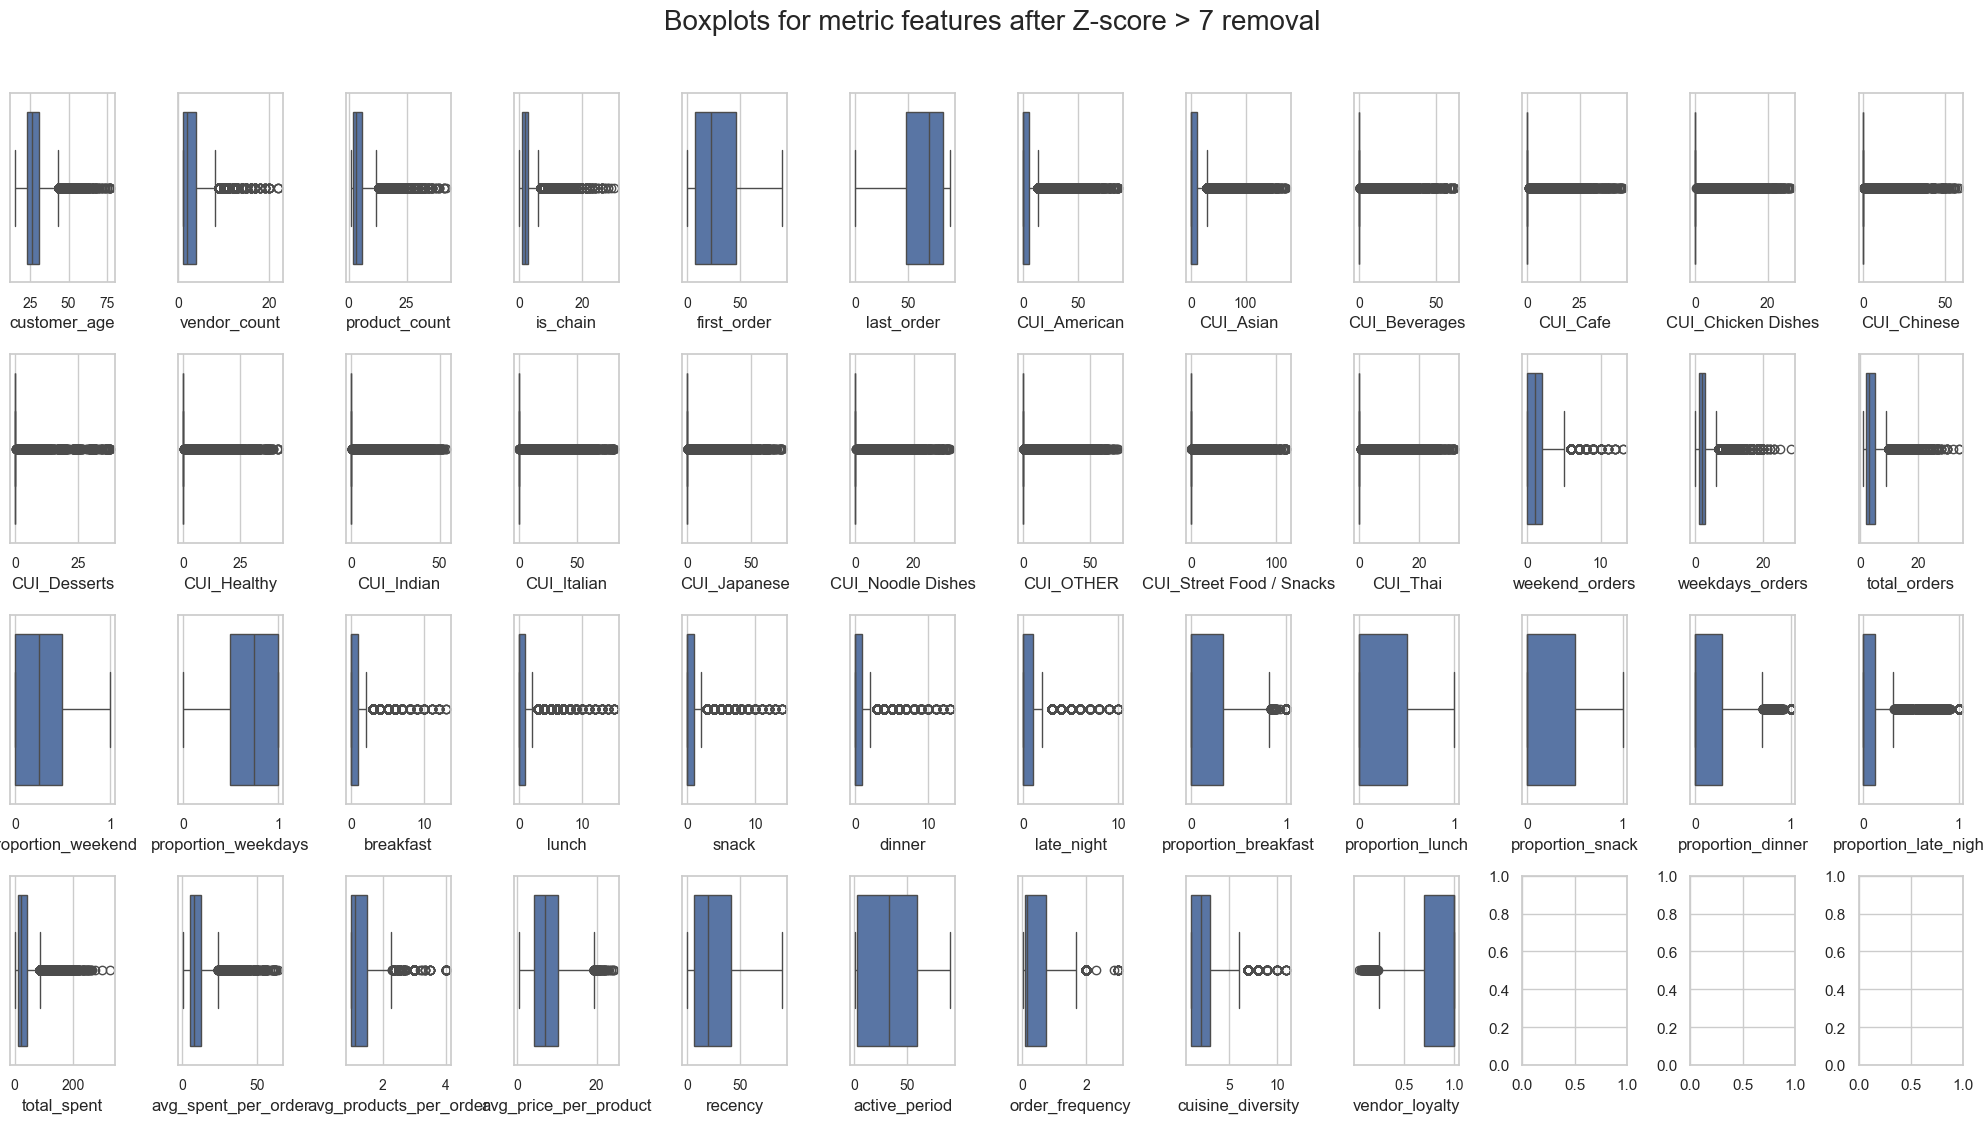

In [57]:
# Boxplots for metric features
sp_rows=4
sp_cols=ceil(len(metric_features) / sp_rows)

# Prepare figure and create individual axes
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 11), tight_layout=True)

# Plot data
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df_cleaned[feat], ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=10)  # Tick size

# Ttitle of the figure
plt.suptitle("Boxplots for metric features after Z-score > 7 removal", fontsize=20, y=1.02)

# Show the plot
plt.show()

<a class="anchor" id="scaling">

## **2.9 Scaling**

</a>

Standard scaler:

In [58]:
std_scaler = StandardScaler()
df_scaled_stnd = std_scaler.fit_transform(df_cleaned[metric_features])

# Convert to array
df_scaled_stnd = pd.DataFrame(df_scaled_stnd, columns=metric_features, index=df_cleaned.index)

# Concatenate with non metric features
df_scaled_stnd = pd.concat([df_scaled_stnd, df_cleaned[non_metric_features]], axis=1)

In [59]:
df_scaled_stnd.head(10)

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,...,cuisine_diversity,vendor_loyalty,customer_region,last_promo,payment_method,age_group,use_promo,weekend_preference,meal_time_preference,cuisine_preference
customer_id,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,-1.349452,-0.389077,0.040521,-0.512036,-1.206775,-2.662974,-0.460767,-0.478193,-0.314716,-0.159471,...,-0.870187,0.673444,2360,DELIVERY,DIGI,young,True,True,dinner,CUI_Indian
5d272b9dcb,-1.491482,-0.389077,-0.625394,-0.164197,-1.206775,-2.662974,0.889569,-0.138681,-0.314716,-0.159471,...,-0.148134,0.673444,8670,DISCOUNT,DIGI,young,True,True,breakfast,CUI_American
f6d1b2ba63,1.491139,-0.824297,-0.625394,-0.164197,-1.206775,-2.662974,0.508273,-0.478193,-0.314716,-0.159471,...,-0.870187,-1.623501,4660,DISCOUNT,CASH,adult,True,True,breakfast,CUI_American
180c632ed8,0.070843,-0.389077,-0.403423,-0.512036,-1.206775,-2.619989,-0.460767,0.249713,-0.314716,-0.159471,...,-0.148134,0.673444,4660,DELIVERY,DIGI,adult,True,False,lunch,CUI_Indian
4eb37a6705,-1.065393,-0.389077,0.040521,-0.859876,-1.206775,-2.619989,1.073897,1.693303,-0.314716,-0.159471,...,-0.148134,0.673444,4660,No Promo Code,DIGI,young,False,False,breakfast,CUI_Asian
6aef2b6726,1.775198,-0.389077,-0.625394,-0.859876,-1.206775,-2.619989,-0.460767,0.845851,-0.314716,-0.159471,...,-0.870187,0.673444,8670,FREEBIE,DIGI,adult,True,False,late_night,CUI_Asian
8475ee66ef,-0.497275,-0.389077,-0.625394,-0.164197,-1.206775,-2.619989,0.158576,-0.478193,-0.064189,-0.159471,...,-0.148134,0.673444,2440,No Promo Code,CARD,adult,False,False,lunch,CUI_American
f2f53bcc67,-0.071186,-0.389077,-0.403423,-0.164197,-1.206775,-2.619989,0.772652,-0.478193,3.680616,-0.159471,...,-0.148134,0.673444,8670,DISCOUNT,DIGI,adult,True,False,breakfast,CUI_Beverages
5b650c89cc,-1.065393,0.046142,-0.181451,-0.164197,-1.206775,-2.577005,-0.171109,-0.478193,-0.314716,-0.159471,...,0.573919,0.673444,2360,DISCOUNT,DIGI,young,True,True,snack,CUI_OTHER


Check the mean and standard deviation, because it should be 0 and 1, respectively:

In [60]:
df_scaled_stnd.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
customer_age,30211.0,0.0,1.0,-1.78,-0.64,-0.21,0.50,7.03
vendor_count,30211.0,0.0,1.0,-0.82,-0.82,-0.39,0.48,8.32
product_count,30211.0,-0.0,1.0,-0.85,-0.63,-0.40,0.26,8.25
is_chain,30211.0,-0.0,1.0,-0.86,-0.51,-0.16,0.18,9.58
first_order,30211.0,0.0,1.0,-1.21,-0.88,-0.25,0.70,2.52
last_order,30211.0,0.0,1.0,-2.71,-0.64,0.30,0.86,1.16
CUI_American,30211.0,-0.0,1.0,-0.46,-0.46,-0.46,0.09,8.60
CUI_Asian,30211.0,0.0,1.0,-0.48,-0.48,-0.48,0.14,8.82
CUI_Beverages,30211.0,0.0,1.0,-0.31,-0.31,-0.31,-0.31,9.79
CUI_Cafe,30211.0,0.0,1.0,-0.16,-0.16,-0.16,-0.16,14.45


<a class="anchor" id="features">

# **3. Analyze features**

</a>

**Check redundancy:**

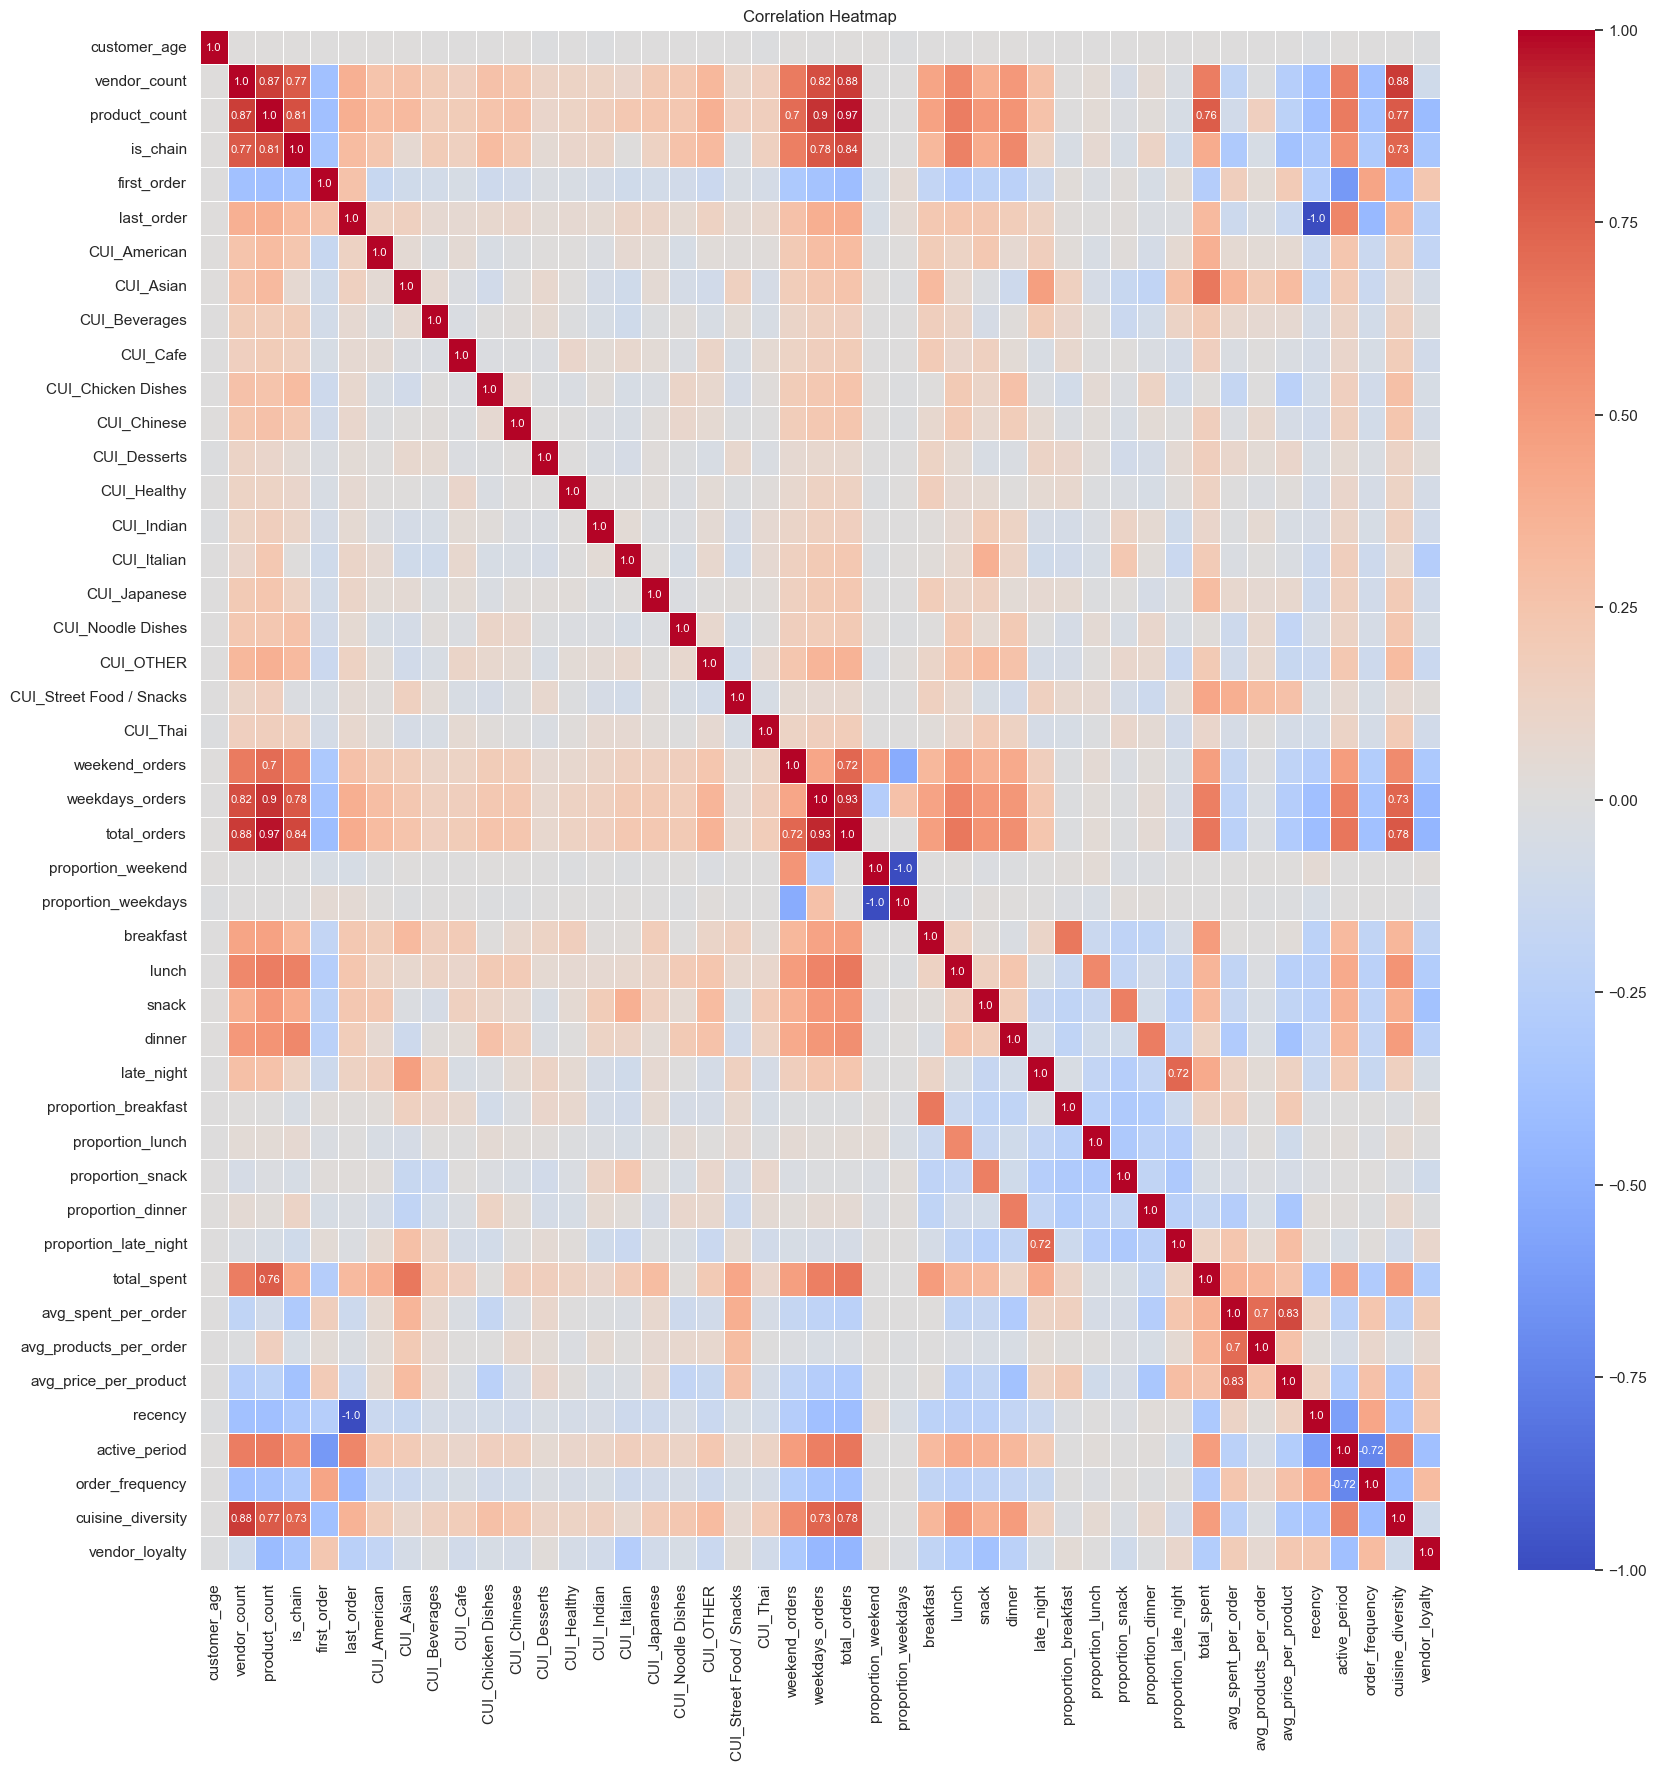

In [61]:
# Spearman's correlation
metric_features_corr = df_scaled_stnd[metric_features]

corr = metric_features_corr.corr(method="pearson")

corr = np.round(metric_features_corr.corr(method="pearson") , decimals=2)

# Heatmap: above 0.7
plt.figure(figsize=(20, 20))
mask_annot = np.absolute(corr.values) >= 0.7
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

sns.heatmap(data=corr,annot=annot,
            cmap="coolwarm", fmt='s', linewidths=0.5,annot_kws={"size": 8})

plt.title("Correlation Heatmap")
plt.show()

- `recency` and `last_order` hold the same information, we will keep recency for cluster interpretability.
- `vendor_count`, `product_count` and `is_chain` are redundant with several other variables.
- `total_spent`and `total_orders`are redundant with several other variables.
- `active_period` and `order_frequency` are redundant.
- `avg_spent_per_order`is redundant with several other variables.

**Check low correlations:**

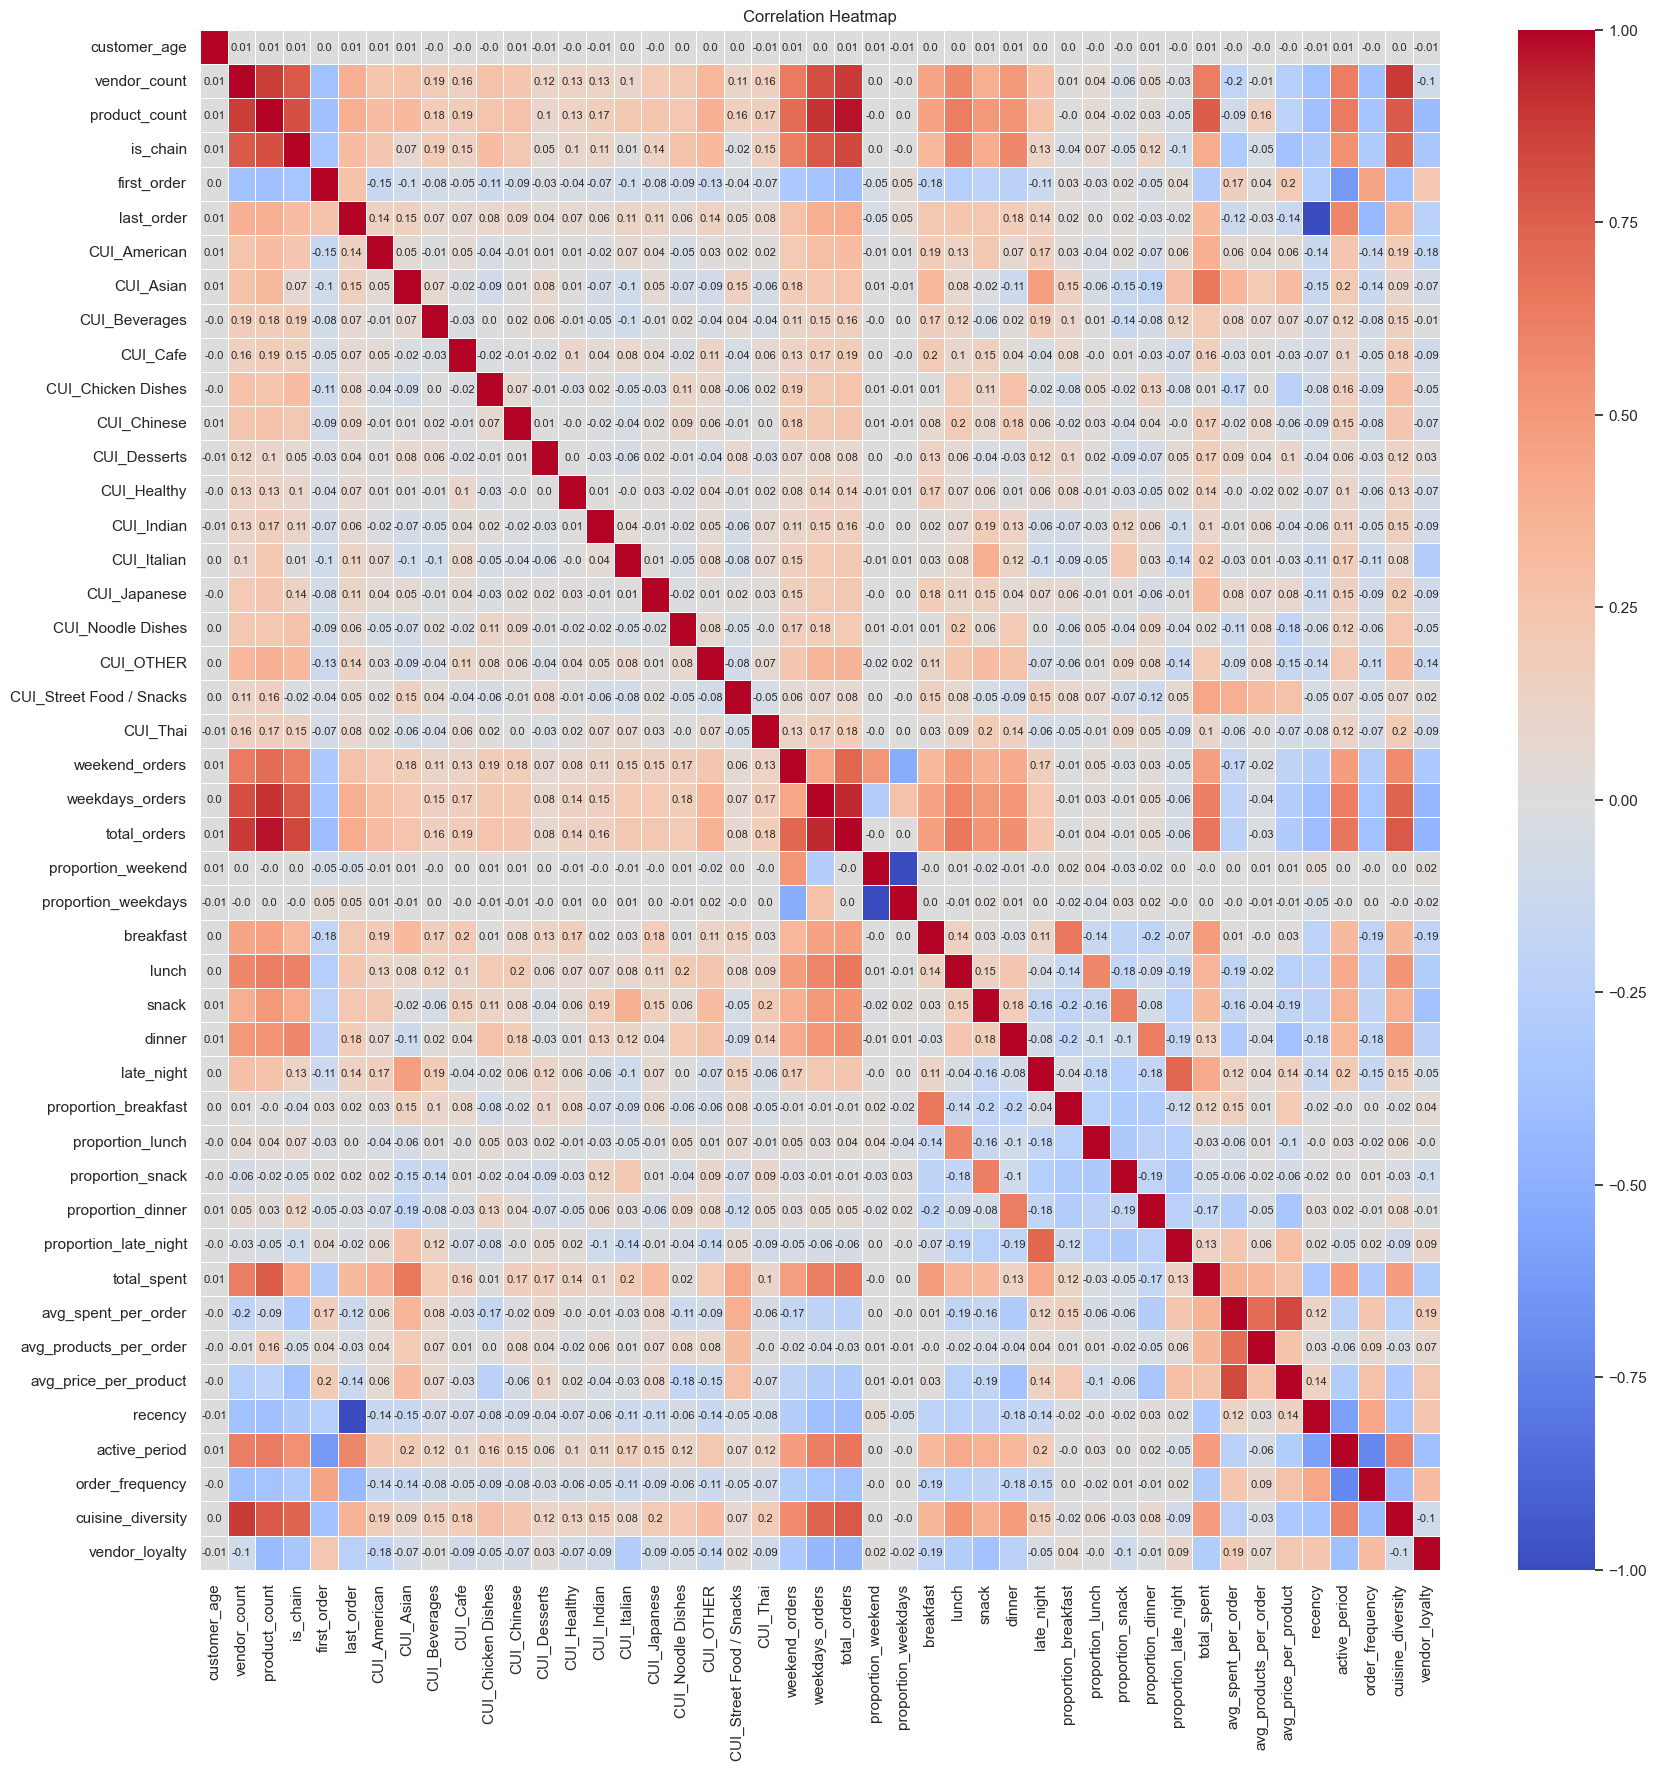

In [62]:
# Spearman's correlation
metric_features_corr = df_scaled_stnd[metric_features]

corr = metric_features_corr.corr(method="pearson")

corr = np.round(metric_features_corr.corr(method="pearson") , decimals=2)

# Heatmap: below 0.2
plt.figure(figsize=(20, 20))
mask_annot = np.absolute(corr.values) <= 0.2
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

sns.heatmap(data=corr,annot=annot,
            cmap="coolwarm", fmt='s', linewidths=0.5,annot_kws={"size": 8})

plt.title("Correlation Heatmap")
plt.show()

- `customer_age` seems to have very little correlation with other features.
- `avg_products_per_order`seems to have very little correlation with other features.
- `active_period` shows greater correlation with the generality of the features than `order_frequency`.
- The cuisine types in general show little correlations with other variables.

**Mean absolute difference:**

In [63]:
mad_values = []

for feature in df_scaled_stnd[metric_features].columns:
    feature_values = df_scaled_stnd[feature]
    
    mean_arithmetic = np.mean(feature_values)
    
    mad = np.mean(np.abs(feature_values - mean_arithmetic))
    
    mad_values.append(mad)

mad_df = pd.DataFrame({
    'Feature': df_scaled_stnd[metric_features].columns,
    'MAD': mad_values
})

mad_df = mad_df.sort_values(by='MAD', ascending=False)

print(mad_df)

                     Feature       MAD
41             active_period  0.886450
44            vendor_loyalty  0.847522
42           order_frequency  0.839656
4                first_order  0.838773
33          proportion_snack  0.831183
32          proportion_lunch  0.830072
5                 last_order  0.826891
40                   recency  0.826891
24        proportion_weekend  0.823000
25       proportion_weekdays  0.823000
39     avg_price_per_product  0.815165
31      proportion_breakfast  0.794937
34         proportion_dinner  0.786449
38    avg_products_per_order  0.754930
43         cuisine_diversity  0.748714
35     proportion_late_night  0.746436
0               customer_age  0.744743
37       avg_spent_per_order  0.729874
1               vendor_count  0.703740
21            weekend_orders  0.703163
36               total_spent  0.701596
22           weekdays_orders  0.701546
2              product_count  0.696991
23              total_orders  0.694557
26                 breakf

**Highest mean absolute difference**: active_period, vendor_loyalty, first_order, order_frequency, recency, avg_price_per_product, cuisine_diversity, costumer_age, avg_products_per_order.

**EDA INSIGHTS:**
- `customer_age` has a low correlation with other variables, but our EDA showed that this variable affects spending habits and preferences. It may be used as a segmentation feature or we can select the new variable `age_group` as a profiling feature.
- We indentified client trends based on first_order and last_order which gave us conclusions related to `active_period` and `recency`, which indicates this last two variables should be included as segmentations features.
- We also had insights related to the number of products and vendors, indicating that related variables may contribute for customer segmentation. As such, `vendor_loyalty`, `avg_products_per_order`, `avg_price_per_product` may be good segmentations features.
- While most of the customers tend to have a set of cuisines they order from, ther are customers that have specifc preference for some types of cusine. `cuisine_diversity` can be included as a segmentation variable for experimentation.
- `weekend_orders` and `weekdays_orders` might be relevant features to identify customer habits, our EDA showed customers have preference from a range of days rather than a specific which may be related to ordering during the weekdays or weekend.
- `lunch`, `dinner`and `late_night` were the most commons times of the day where customers order, it is likely that customers may have a preference for a specifc time, e.g. night shifters may order at late night but are unlikely to order at lunch.
- `payment_method` and `use_promo` seems to affect spending habits, which can make them good candidates for profiling features.
- `customer_region`seems to influence cuisine diversity and promotions, as such it can be used as a profiling feature.

**Starting point for segmentations features:**
- "active_period", "vendor_loyalty", "order_frequency", "recency", "avg_spent_per_order", "avg_products_per_order", "cuisine_diversity", "proportion_weekends", "proportion_weekdays", "total_orders", "total_spent", "product_count"

In [64]:
# Save preprocessed dataset
df_scaled_stnd.to_parquet('Data_preprocessed.parquet')
df_original_values.to_parquet('Data_original_values.parquet')